In [30]:
import numpy as np
import pydicom
import pandas as pd
from datetime import datetime as dt
from glob import glob

import subtle.utils.io as suio
import skimage.morphology as morph
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
plt.set_cmap('gray')
plt.rcParams["figure.figsize"] = (10, 8)

def get_dcm(dirpath_dcm):
    return pydicom.dcmread([fpath for fpath in glob('{}/*'.format(dirpath_dcm))][0])

def get_time_str(time_str):
    return time_str.split('.')[0]

def get_diff_in_secs(time1, time2):
    dt_format = '%H%M%S'
    
    t1 = dt.strptime(time1, dt_format)
    t2 = dt.strptime(time2, dt_format)
    
    return (t2-t1).seconds

def get_time_diff(path_zero, path_low, path_full):
    dcm_zero = get_dcm(path_zero)
    dcm_low = get_dcm(path_low)
    dcm_full = get_dcm(path_full)
    
    zero_dict = get_time_str(dcm_zero.AcquisitionTime)
    low_dict = get_time_str(dcm_low.AcquisitionTime)
    full_dict = get_time_str(dcm_full.AcquisitionTime)
    return {
        'low_zero': get_diff_in_secs(zero_dict, low_dict),
        'full_low': get_diff_in_secs(low_dict, full_dict)
    }

def compile_time_info(dirpath_dcm):
    paths = suio.get_dicom_dirs(dirpath_dcm)
    if len(paths) < 3:
        return None
    return get_time_diff(paths[0], paths[1], paths[2]) 

def get_mean_acqtime(dirpath_dcms):
    diff_dict = {}
    for dirpath_dcm in dirpath_dcms:
        case_num = dirpath_dcm.split('/')[-1]
        time_info = compile_time_info(dirpath_dcm)
        if time_info is not None:
            diff_dict[case_num] = time_info

    df_diff = pd.DataFrame(diff_dict).T
    return {
        'mean': dict(df_diff.mean()),
        'std': dict(df_diff.std())
    }

def show_img(img, title='', axis=False, vmin=None, vmax=None, colorbar=False, fname=None):
    plt.clf()
    imshow_args = {}
    
    if vmin:
        imshow_args['vmin'] = vmin
    if vmax:
        imshow_args['vmax'] = vmax
    
    im_axis = 'on' if axis else 'off'
    plt.axis(im_axis)
    plt.imshow(img, **imshow_args)
    plt.title(title, fontsize=15)
    
    if fname is not None:
        plt.savefig(fname)

def show_gad_comparison(img_pre, img_low, img_post):
    fig = plt.figure(figsize=(18, 12))
    fig.tight_layout()

    fig.add_subplot(1, 3, 1)
    show_img(img_pre, title='Pre contrast')

    fig.add_subplot(1, 3, 2)
    show_img(img_low, title='10% dosage')

    fig.add_subplot(1, 3, 3)
    show_img(img_post, title='Full dosage')

    plt.show()

def get_enhancement(img1, img2):
    diff = img2-img1
    diff = np.interp(diff, (diff.min(), diff.max()), (0, 1))
    diff = diff > 0.1
    return diff

def get_mean_enhancement(fpath_h5, full_ref=False, h5_key='data_mask'):
    study_data = suio.load_file(fpath_h5, params={'h5_key': h5_key})
    if study_data.ndim == 5:
        study_data = study_data[1]
    zero_vol = study_data[:, 0, ...]
    low_vol = study_data[:, 1, ...]
    full_vol = study_data[:, 2, ...]
    
    if full_ref:
        diff_vol = full_vol - low_vol
    else:
        diff_vol = low_vol - zero_vol
    diff_vol[diff_vol < 0] = 0
    diff_vol = diff_vol > 0.15
    
    enh_mask = morph.remove_small_objects(diff_vol)
#     enh_mask = morph.binary_erosion(enh_mask, selem=morph.cube(3))
#     enh_mask = morph.binary_dilation(enh_mask)
    
    if full_ref:
        enh_img = full_vol * enh_mask
    else:
        enh_img = low_vol * enh_mask
    
    case_num = fpath_h5.split('/')[-1].replace('.h5', '')
    pidx = enh_img.shape[0] // 2
    show_img(enh_img[pidx], fname='enh_imgs/{}.png'.format(case_num))
    
    return enh_img[np.nonzero(enh_img)].max()

<Figure size 720x576 with 0 Axes>

In [11]:
base_path = '/home/srivathsa/projects/studies/gad/tiantan/data'
dirpath_dcms = sorted(glob('{}/NO*'.format(base_path)))
print(get_mean_acqtime(dirpath_dcms))

{'mean': {'low_zero': 370.5853658536585, 'full_low': 180.3170731707317}, 'std': {'low_zero': 66.96690747509606, 'full_low': 18.766188434654232}}


In [44]:
base_path = '/home/srivathsa/projects/studies/gad/hoag/data'
dirpath_dcms = [f for f in sorted(glob('{}/*'.format(base_path))) if 'Id' in f]
print(get_mean_acqtime(dirpath_dcms))

{'mean': {'full_low': 676.7741935483871, 'low_zero': 1403.0}, 'std': {'full_low': 209.12878164381863, 'low_zero': 321.7739372085108}}


In [19]:
base_path = '/home/srivathsa/projects/studies/gad/stanford/data'
dirpath_dcms = [f for f in sorted(glob('{}/*'.format(base_path))) if 'Patient' in f]
print(get_mean_acqtime(dirpath_dcms))

{'mean': {'low_zero': 1138.6802721088436, 'full_low': 791.5238095238095}, 'std': {'low_zero': 5380.932678938569, 'full_low': 4031.8811360771215}}


In [46]:
base_path = '/home/srivathsa/projects/studies/gad/sford_siemens/data'
dirpath_dcms = [f for f in sorted(glob('{}/*'.format(base_path))) if 'Patient' in f]
print(get_mean_acqtime(dirpath_dcms))

{'mean': {'full_low': 564.1481481481482, 'low_zero': 738.925925925926}, 'std': {'full_low': 32.858324906627786, 'low_zero': 144.19002577419678}}


/home/srivathsa/miniconda3/envs/py35gad/lib/python3.6/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/441 [00:00<?, ?it/s]

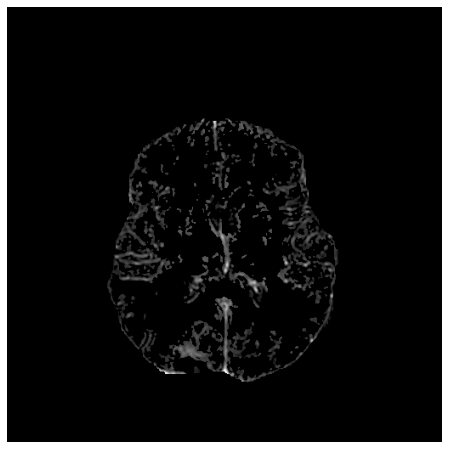

In [43]:
pp_base = '/home/srivathsa/projects/studies/gad/stanford/preprocess/data'
dcm_base = '/home/srivathsa/projects/studies/gad/stanford/data'

data_points = []
fail_points = []

# fail_cases = ['NO31', 'NO39', 'NO44', 'NO57', 'NO65']
fail_cases = []

dfiles = sorted([f for f in glob('{}/*.npy'.format(pp_base)) 
                 if 'meta' not in f and 'Prisma' not in f and 'TwoDim' not in f])

for fpath_h5 in tqdm(dfiles, total=len(dfiles)):
    case_num = fpath_h5.split('/')[-1].replace('.npy', '')
    dcm_path = '{}/{}'.format(dcm_base, case_num)
    acq_dict = compile_time_info(dcm_path)
    if not acq_dict:
        continue
    mean_en = get_mean_enhancement(fpath_h5)
    mean_en2 = get_mean_enhancement(fpath_h5, full_ref=True)
    if case_num in fail_cases:
        fail_points.append((acq_dict['low_zero'], mean_en, acq_dict['full_low'], mean_en2))
    else:
        data_points.append((acq_dict['low_zero'], mean_en, acq_dict['full_low'], mean_en2))
#     print(case_num, acq_dict['low_zero'], mean_en)

Text(0, 0.5, 'Mean enhancement value')

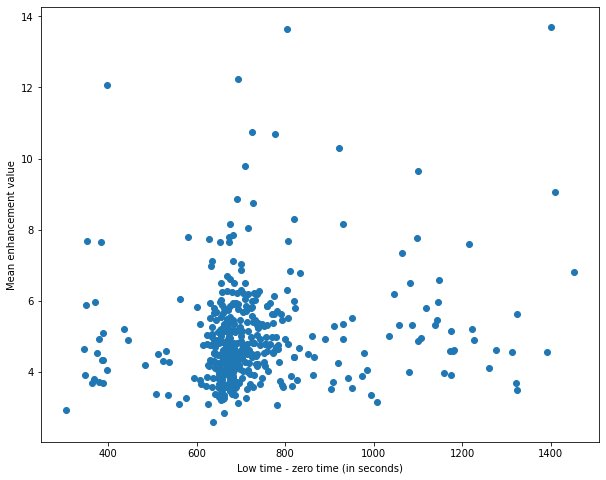

In [45]:
data_points = np.array(data_points)
data_points_filt = np.array([p for p in data_points if p[0] < 1500])
# fail_points = np.array(fail_points)
plt.scatter(data_points_filt[:, 0], data_points_filt[:, 1])
# plt.scatter(fail_points[:, 0], fail_points[:, 1], c='r')
plt.xlabel('Low time - zero time (in seconds)')
plt.ylabel('Mean enhancement value')

Text(0, 0.5, 'Mean enhancement value')

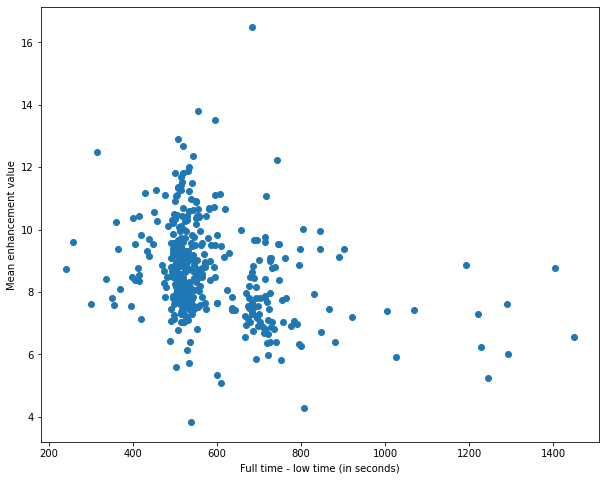

In [48]:
data_points_filt = np.array([p for p in data_points if p[2] < 1500 and p[3] < 50])
plt.scatter(data_points_filt[:, 2], data_points_filt[:, 3])
# plt.scatter(fail_points[:, 2], fail_points[:, 3], c='r')
plt.xlabel('Full time - low time (in seconds)')
plt.ylabel('Mean enhancement value')